In [55]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])


import warnings
warnings.filterwarnings('ignore')


we're going to be trying to infer which was the real driver rather than produce best predictions now

In [56]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

In [57]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

In [58]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

In [60]:
combined_data = pd.concat([train, test], axis=0)
data = combined_data.reset_index(drop=True)
display(data.head())

,feature_1,feature_2,feature_3,feature_4,id,date,y
0,0.010375,0.036759,-0.119788,-0.411122,50501,2000,0
1,-0.288599,0.009534,-0.163601,1.002341,50501,2001,1
2,-0.215511,-1.144393,-0.117179,1.365486,50501,2002,0
3,-0.202501,-0.084943,-0.172643,0.152874,50501,2003,0
4,-0.174256,-1.669301,-0.074701,1.903661,50501,2004,0


In [61]:
data['feature_1_x_2'] = data['feature_1'] * data['feature_2']
data['feature_1_x_3'] = data['feature_1'] * data['feature_3'] 
data['feature_1_x_4'] = data['feature_1'] * data['feature_4']
data['feature_2_x_3'] = data['feature_2'] * data['feature_3']
data['feature_2_x_4'] = data['feature_2'] * data['feature_4']
data['feature_3_x_4'] = data['feature_3'] * data['feature_4']

In [62]:
from pymer4.models import Lmer

model = Lmer("y ~ feature_1 + feature_2 + feature_3 + feature_4 + (1|id)", data=data, family='binomial')

print(model.fit(control="optimizer='bobyqa'"))

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~feature_1+feature_2+feature_3+feature_4+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 5000	 Groups: {'id': 401.0}

Log-likelihood: -1988.499 	 AIC: 3988.998

Random effects:

           Name    Var    Std
id  (Intercept)  0.013  0.114

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -3.398  -3.617   -3.178  0.112  0.033      0.027       0.042   
feature_1       0.291   0.080    0.502  0.108  1.338      1.084       1.652   
feature_2      -0.280  -0.366   -0.194  0.044  0.756      0.693       0.823   
feature_3     -11.724 -12.927  -10.522  0.613  0.000      0.000       0.000   
feature_4       0.464   0.364    0.564  0.051  1.591      1.439       1.758   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.032        0.026         0.040 -30.325  0.000  ***  


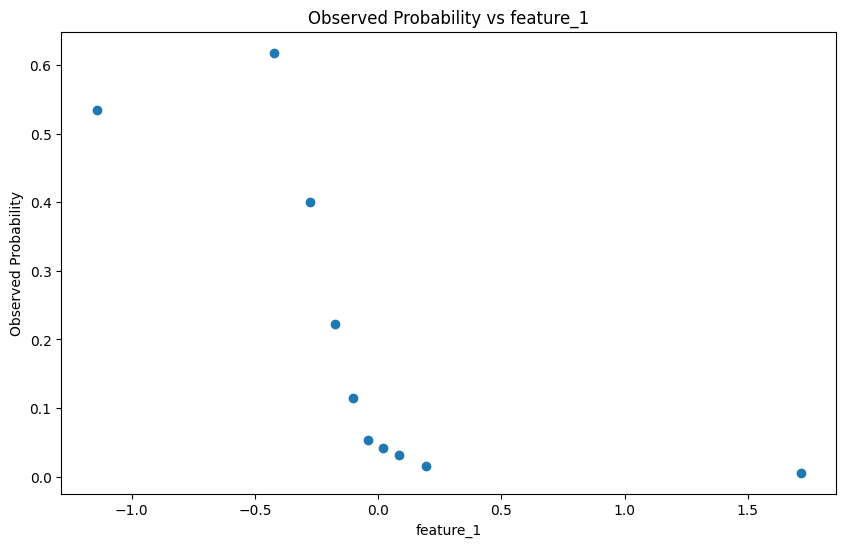

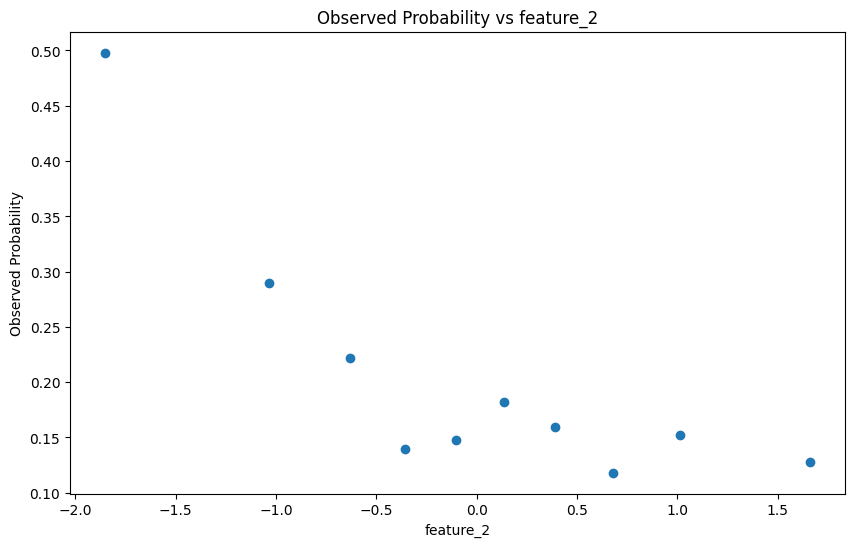

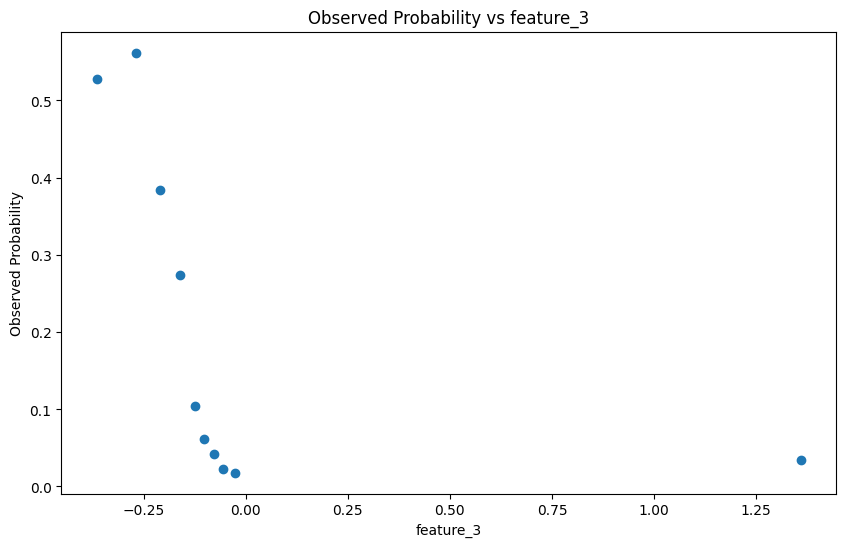

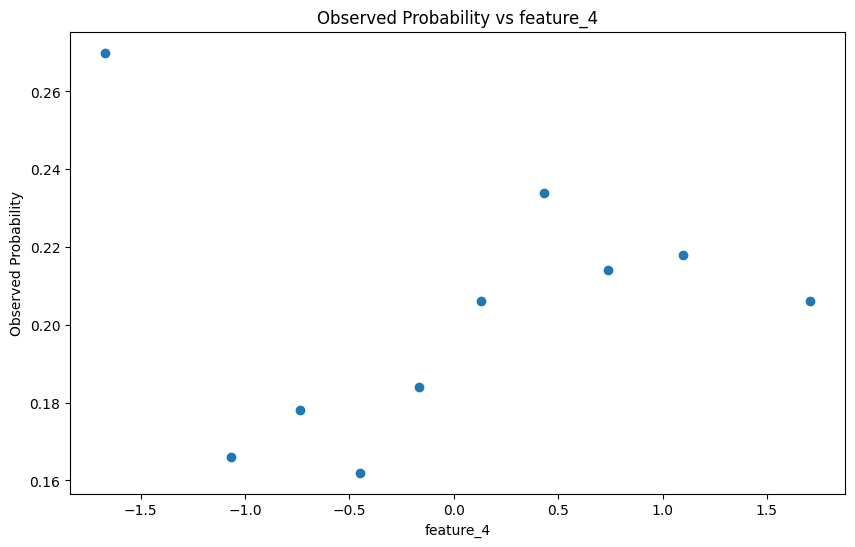

In [63]:
for feature in ['feature_1', 'feature_2', 'feature_3', 'feature_4']:
    bins = pd.qcut(data[feature], q=10, labels=False)
    avg_prob = data.groupby(bins)['y'].mean()
    bin_centers = data.groupby(bins)[feature].mean()

    plt.figure(figsize=(10,6))
    plt.scatter(bin_centers, avg_prob)
    plt.xlabel(feature)
    plt.ylabel('Observed Probability')
    plt.title(f'Observed Probability vs {feature}')
    plt.show()
